# Electric Grid Optimization using QAOA

We have a set of N power plants (sources), and M consumers. The goal is to supply power to all consumers, meeting the constraints of the power plants, and minimize the total cost of supplying power. The presented model has small variation from [[1](#OpPwer)].

Mathematical model, minimize the objective function:

$$z = \sum_{i=1}^{n} \sum_{j=1}^{m} Z_{ij}x_{ij}$$

where $x_{ij}$ is the required values of the transmitted power from source $A_i$ to consumer $B_j$.

The unit cost of transmitting power from node $A_i$ to node $B_j$ is $Z_{ij}$.

Constraint to:

The sum of powers flowing from power plant transmission lines to all customer nodes must be up to the power of the source $A_i$

$$ \sum_{j=1}^{M} x_{ij} \leq A_{i}   \quad    i=1,2,...,N$$

Each consumer recieve power $B_{j}$:

$$ \sum_{i=1}^{N} x_{ij} = B_{j}   \quad    j=1,2,...,M$$

We take $B_{j} = 1$ and $A_{i} = 2$ in the following example.

Notice that we use 2 kinds of constraints, equality and inequality.

## Building the problem

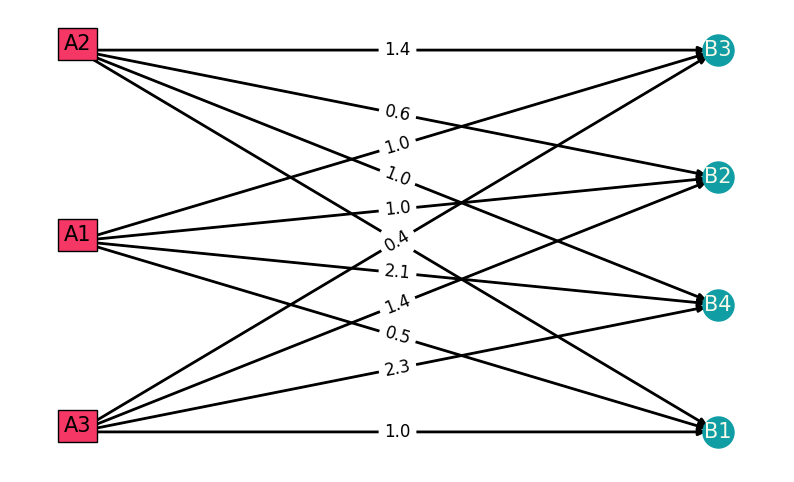

In [7]:
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx  # noqa
import numpy as np
import pandas as pd

# building data matrix, it doesn't need to be a symmetric matrix.
cost_matrix = np.array(
    [[0.5, 1.0, 1.0, 2.1], [1.0, 0.6, 1.4, 1.0], [1.0, 1.4, 0.4, 2.3]]
)

Sources = ["A1", "A2", "A3"]
Consumers = ["B1", "B2", "B3", "B4"]

# number of sources
N = len(Sources)
# number of consumers
M = len(Consumers)

graph = nx.DiGraph()
graph.add_nodes_from(Sources + Consumers)
for n, m in product(range(N), range(M)):
    graph.add_edges_from([(Sources[n], Consumers[m])], weight=cost_matrix[n, m])


# Plot the graph
plt.figure(figsize=(10, 6))
left = nx.bipartite.sets(graph)[0]
pos = nx.bipartite_layout(graph, left)

nx.draw_networkx(graph, pos=pos, nodelist=Consumers, font_size=22, font_color="None")
nx.draw_networkx_nodes(
    graph, pos, nodelist=Consumers, node_color="#119DA4", node_size=500
)
for fa in Sources:
    x, y = pos[fa]
    plt.text(
        x,
        y,
        s=fa,
        bbox=dict(facecolor="#F43764", alpha=1),
        horizontalalignment="center",
        fontsize=15,
    )

nx.draw_networkx_edges(graph, pos, width=2)
labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_size=12)
nx.draw_networkx_labels(
    graph,
    pos,
    labels={co: co for co in Consumers},
    font_size=15,
    font_color="#F4F9E9",
)

plt.axis("off")
plt.show()

### building the pyomo model - classical combinatorial optimization problem

In [8]:
import pyomo.environ as pyo
from IPython.display import Markdown, display

opt_model = pyo.ConcreteModel()

sources_lst = range(N)
consumers_lst = range(M)

opt_model.x = pyo.Var(sources_lst, consumers_lst, domain=pyo.Binary)


@opt_model.Constraint(sources_lst)
def source_supply_rule(model, n):  # constraint (1)
    return sum(model.x[n, m] for m in consumers_lst) <= 2


@opt_model.Constraint(consumers_lst)
def each_consumer_is_supplied_rule(model, m):  # constraint (2)
    return sum(model.x[n, m] for n in sources_lst) == 1


opt_model.cost = pyo.Objective(
    expr=sum(
        cost_matrix[n, m] * opt_model.x[n, m]
        for n in sources_lst
        for m in consumers_lst
    ),
    sense=pyo.minimize,
)

Printing the classical optimization problem

In [9]:
opt_model.pprint()

5 Set Declarations
    each_consumer_is_supplied_rule_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {0, 1, 2, 3}
    source_supply_rule_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :   12 : {(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {0, 1, 2, 3}

1 Var Declarations
    x : Size=12, Index=x_index
        Key    : Lower : V

## Solving with Classiq
We take a specific example: the one outlined above.

### First generating parameters for the quantum circuit

In [10]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=opt_model, num_layers=6, penalty_factor=8)

qmod = combi.get_model()
write_qmod(qmod, "electric_grid_optimization")

We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [14]:
%%time
cost_values = []
optimized_params = combi.optimize(maxiter=100, cost_trace=cost_values, quantile=1)

ClassiqAPIError: Internal error occurred. Please contact Classiq support.
Error number 122001 occurred:

Error identifier: E1F6D3DA2-C8A2-4BC3-9ED6-9F88BB83A16E
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack

We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

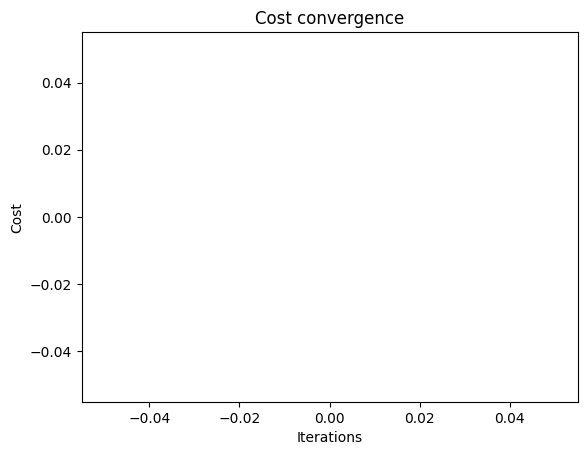

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(cost_values)
axes.set_xlabel("Iterations")
axes.set_ylabel("Cost")
axes.set_title("Cost convergence")

## Get best solution statistics

In [11]:
optimization_result = combi.get_results()
optimization_result.sort_values(by="cost").head(5)

,probability,cost,solution,count
160,0.001,3.6,"[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]",1
0,0.003,4.1,"[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]",3
435,0.001,4.1,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]",1
5,0.002,4.1,"[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]",2
802,0.001,4.3,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]",1


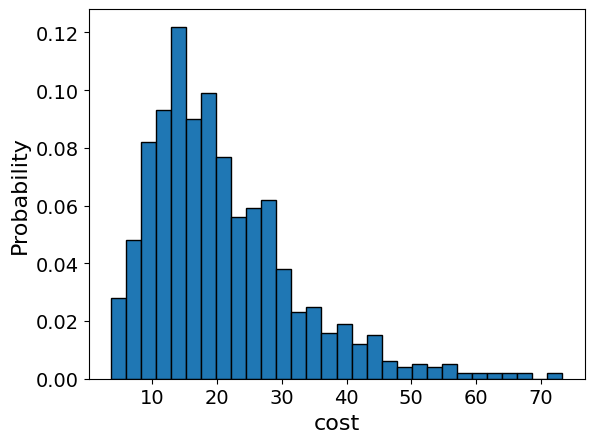

In [12]:
optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

## Best solution visulalization

In [16]:
# This function plots the solution in a table and a graph


def plotting_sol(x_sol, cost, is_classic: bool):
    x_sol_to_mat = np.reshape(np.array(x_sol), [N, M])  # vector to matrix
    # opened facilities will be marked in red
    opened_fac_dict = {}
    for fa in range(N):
        if sum(x_sol_to_mat[fa, m] for m in range(M)) > 0:
            opened_fac_dict.update({Sources[fa]: "background-color: #F43764"})

    # classical or quantum
    if is_classic == True:
        display(Markdown("**CLASSICAL SOLUTION**"))
        print("total cost= ", cost)
    else:
        display(Markdown("**QAOA SOLUTION**"))
        print("total cost= ", cost)

    # plotting in a table
    df = pd.DataFrame(x_sol_to_mat)
    df.columns = Consumers
    df.index = Sources
    plotable = df.style.apply(lambda x: x.index.map(opened_fac_dict))
    display(plotable)

    # plotting in a graph
    graph_sol = nx.DiGraph()
    graph_sol.add_nodes_from(Sources + Consumers)
    for n, m in product(range(N), range(M)):
        if x_sol_to_mat[n, m] > 0:
            graph_sol.add_edges_from(
                [(Sources[n], Consumers[m])], weight=cost_matrix[n, m]
            )

    plt.figure(figsize=(10, 6))
    left = nx.bipartite.sets(graph_sol, top_nodes=Sources)[0]
    pos = nx.bipartite_layout(graph_sol, left)

    nx.draw_networkx(
        graph_sol, pos=pos, nodelist=Consumers, font_size=22, font_color="None"
    )
    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=Consumers, node_color="#119DA4", node_size=500
    )
    for fa in Sources:
        x, y = pos[fa]
        if fa in opened_fac_dict.keys():
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F43764", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )
        else:
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F4F9E9", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )

    nx.draw_networkx_edges(graph_sol, pos, width=2)
    labels = nx.get_edge_attributes(graph_sol, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_size=12)
    nx.draw_networkx_labels(
        graph_sol,
        pos,
        labels={co: co for co in Consumers},
        font_size=15,
        font_color="#F4F9E9",
    )

    plt.axis("off")
    plt.show()


best_solution = optimization_result.loc[optimization_result.cost.idxmin()]

plotting_sol(
    [best_solution.solution[f"x_{i}"] for i in range(len(best_solution.solution))],
    best_solution.cost,
    is_classic=False,
)

NameError: name 'optimization_result' is not defined

### Compare to a classical solver

In [14]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(opt_model)

# opt_model.display()

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 12, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'couenne\\x3a Optimal', 'Termination condition': 'optimal', 'Id': 3, 'Error rc': 0, 'Time': 0.016887187957763672}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

**CLASSICAL SOLUTION**

total cost=  2.4999999996418167


,B1,B2,B3,B4
A1,1.000000,0.000000,0.000000,0.000000
A2,0.000000,1.000000,0.000000,1.000000
A3,0.000000,-0.000000,1.000000,0.000000


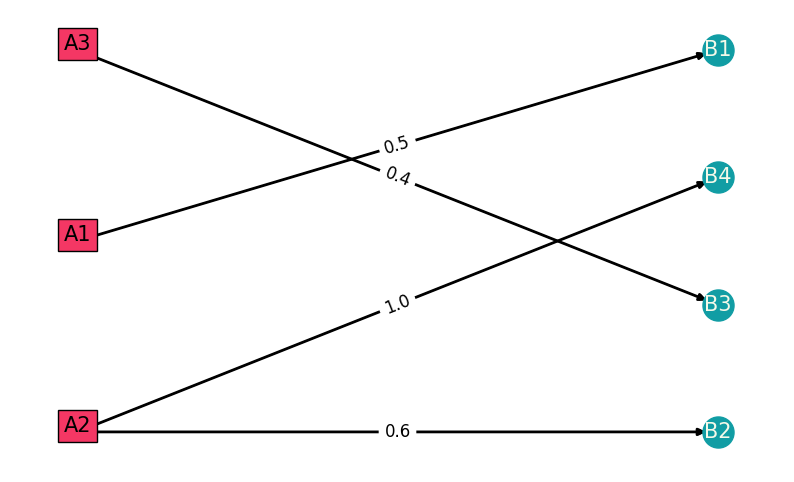

In [15]:
best_classical_solution = np.array(
    [pyo.value(opt_model.x[idx]) for idx in np.ndindex(cost_matrix.shape)]
).reshape(cost_matrix.shape)

plotting_sol(
    np.round([pyo.value(opt_model.x[idx]) for idx in np.ndindex(cost_matrix.shape)]),
    pyo.value(opt_model.cost),
    is_classic=True,
)

<a id='OpPower'>[1]</a>: Solving optimization problems when designing power supply circuits. https://www.e3s-conferences.org/articles/e3sconf/pdf/2019/50/e3sconf_ses18_04011.pdf
